# 準備

## Googleドライブのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [2]:
import sys
sys.path.append('/content/drive/My Drive/DNN_code')

# predict sin

loss: 5.111112056304202e-07    d: [-0.47157024]    y: [-0.47258129]
loss: 1.4153640452727858e-06    d: [-0.39789889]    y: [-0.39958137]
loss: 2.5599029914894717e-06    d: [-0.78740743]    y: [-0.78967013]
loss: 7.2162632907901755e-09    d: [0.25526991]    y: [0.25514977]
loss: 1.692063852303836e-06    d: [0.6529121]    y: [0.6547517]
loss: 7.238070929585727e-07    d: [0.8773359]    y: [0.87613273]
loss: 6.946236726395298e-07    d: [0.92114593]    y: [0.91996727]
loss: 1.2284734878715097e-06    d: [-0.58880346]    y: [-0.59037093]
loss: 1.2497465540405892e-08    d: [-0.6529121]    y: [-0.65307019]
loss: 1.7470122273519936e-06    d: [-0.32751865]    y: [-0.32938788]
loss: 2.0214401036935557e-07    d: [0.39789889]    y: [0.39853473]
loss: 1.7248378220184066e-06    d: [-0.15674537]    y: [-0.1586027]
loss: 1.3462666565767213e-06    d: [0.97076771]    y: [0.97240861]
loss: 6.884294927340995e-07    d: [-0.50453668]    y: [-0.50571008]
loss: 8.96448514571133e-09    d: [-0.99460929]    y: [-0

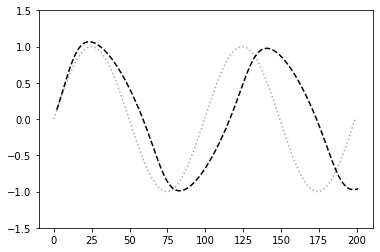

In [3]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(0)

# sin曲線
round_num = 10
div_num = 500
ts = np.linspace(0, round_num * np.pi, div_num)
f = np.sin(ts)

def d_tanh(x):
    return 1/(np.cosh(x)**2 + 1e-4)

# ひとつの時系列データの長さ
maxlen = 2

# sin波予測の入力データ
test_head = [[f[k]] for k in range(0, maxlen)]

data = []
target = []

for i in range(div_num - maxlen):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])
    
X = np.array(data).reshape(len(data), maxlen, 1)
D = np.array(target).reshape(len(data), 1)

# データ設定
N_train = int(len(data) * 0.8)
N_validation = len(data) - N_train

x_train, x_test, d_train, d_test = train_test_split(X, D, test_size=N_validation)

input_layer_size = 1
hidden_layer_size = 5
output_layer_size = 1

weight_init_std = 0.01
learning_rate = 0.1

iters_num = 500

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

us = []
zs = []

u = np.zeros(hidden_layer_size)
z = np.zeros(hidden_layer_size)
y = np.zeros(output_layer_size)

delta_out = np.zeros(output_layer_size)
delta = np.zeros(hidden_layer_size)

losses = []

# トレーニング
for i in range(iters_num):
    for s in range(x_train.shape[0]):
        us.clear()
        zs.clear()
        z *= 0
        
        # sにおける正解データ
        d = d_train[s]

        xs = x_train[s]        
        
        # 時系列ループ
        for t in range(maxlen):
            
            # 入力値
            x = xs[t]
            u = np.dot(x, W_in) + np.dot(z, W)
            us.append(u)
            z = np.tanh(u)
            zs.append(z)

        y = np.dot(z, W_out)
        
        #誤差
        loss = functions.mean_squared_error(d, y)
        
        delta_out = functions.d_mean_squared_error(d, y)
        
        delta *= 0
        for t in range(maxlen)[::-1]:
            
            delta = (np.dot(delta, W.T) + np.dot(delta_out, W_out.T)) * d_tanh(us[t])
            
            # 勾配更新
            W_grad += np.dot(zs[t].reshape(-1,1), delta.reshape(1,-1))
            W_in_grad += np.dot(xs[t], delta.reshape(1,-1))
        W_out_grad = np.dot(z.reshape(-1,1), delta_out)
        
        # 勾配適用
        W -= learning_rate * W_grad
        W_in -= learning_rate * W_in_grad
        W_out -= learning_rate * W_out_grad.reshape(-1,1)
            
        W_in_grad *= 0
        W_out_grad *= 0
        W_grad *= 0

# テスト        
for s in range(x_test.shape[0]):
    z *= 0

    # sにおける正解データ
    d = d_test[s]

    xs = x_test[s]

    # 時系列ループ
    for t in range(maxlen):

        # 入力値
        x = xs[t]
        u = np.dot(x, W_in) + np.dot(z, W)
        z = np.tanh(u)

    y = np.dot(z, W_out)

    #誤差
    loss = functions.mean_squared_error(d, y)
    print('loss:', loss, '   d:', d, '   y:', y)
        
        
        
original = np.full(maxlen, None)
pred_num = 200

xs = test_head

# sin波予測
for s in range(0, pred_num):
    z *= 0
    for t in range(maxlen):
        
        # 入力値
        x = xs[t]
        u = np.dot(x, W_in) + np.dot(z, W)
        z = np.tanh(u)

    y = np.dot(z, W_out)
    original = np.append(original, y)
    xs = np.delete(xs, 0)
    xs = np.append(xs, y)

plt.figure()
plt.ylim([-1.5, 1.5])
plt.plot(np.sin(np.linspace(0, round_num* pred_num / div_num * np.pi, pred_num)), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### [try]
-  iters_numを100にしよう
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

loss: 0.0001072691077170226    d: [-0.31559594]    y: [-0.33024306]
loss: 2.1428896254818414e-05    d: [0.8948329]    y: [0.90137948]
loss: 5.366198355852382e-05    d: [-0.81380058]    y: [-0.82416031]
loss: 1.3156350690066168e-05    d: [0.92114593]    y: [0.92627552]
loss: 4.400960435304569e-09    d: [0.98394564]    y: [0.98403946]
loss: 4.4902306415358384e-06    d: [0.2430756]    y: [0.24607234]
loss: 2.3489520253484713e-06    d: [-0.91617219]    y: [-0.91833965]
loss: 1.9539753205327732e-05    d: [0.03776568]    y: [0.04401704]
loss: 2.3403181465208605e-05    d: [0.88914122]    y: [0.89598274]
loss: 8.079429580603428e-06    d: [-0.02518045]    y: [-0.02116064]
loss: 3.5055927113187806e-09    d: [-0.99085292]    y: [-0.99076919]
loss: 6.365567415844646e-05    d: [0.18775236]    y: [0.19903559]
loss: 6.0155831335916566e-05    d: [-0.79890907]    y: [-0.80987774]
loss: 4.364941593806924e-06    d: [-0.88914122]    y: [-0.89209586]
loss: 1.0678739945534986e-05    d: [-0.82463104]    y: [

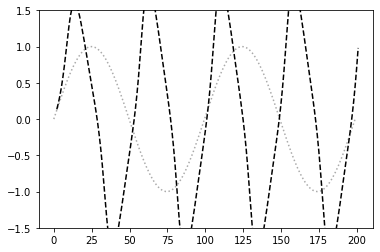

In [4]:
# sin曲線
round_num = 10
div_num = 500
ts = np.linspace(0, round_num * np.pi, div_num)
f = np.sin(ts)

def d_tanh(x):
    return 1/(np.cosh(x)**2 + 1e-4)

# ひとつの時系列データの長さ
maxlen = 2

# sin波予測の入力データ
test_head = [[f[k]] for k in range(0, maxlen)]

data = []
target = []

for i in range(div_num - maxlen):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])
    
X = np.array(data).reshape(len(data), maxlen, 1)
D = np.array(target).reshape(len(data), 1)

# データ設定
N_train = int(len(data) * 0.8)
N_validation = len(data) - N_train

x_train, x_test, d_train, d_test = train_test_split(X, D, test_size=N_validation)

input_layer_size = 1
hidden_layer_size = 5
output_layer_size = 1

weight_init_std = 0.01
learning_rate = 0.1

iters_num = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

us = []
zs = []

u = np.zeros(hidden_layer_size)
z = np.zeros(hidden_layer_size)
y = np.zeros(output_layer_size)

delta_out = np.zeros(output_layer_size)
delta = np.zeros(hidden_layer_size)

losses = []

# トレーニング
for i in range(iters_num):
    for s in range(x_train.shape[0]):
        us.clear()
        zs.clear()
        z *= 0
        
        # sにおける正解データ
        d = d_train[s]

        xs = x_train[s]        
        
        # 時系列ループ
        for t in range(maxlen):
            
            # 入力値
            x = xs[t]
            u = np.dot(x, W_in) + np.dot(z, W)
            us.append(u)
            z = np.tanh(u)
            zs.append(z)

        y = np.dot(z, W_out)
        
        #誤差
        loss = functions.mean_squared_error(d, y)
        
        delta_out = functions.d_mean_squared_error(d, y)
        
        delta *= 0
        for t in range(maxlen)[::-1]:
            
            delta = (np.dot(delta, W.T) + np.dot(delta_out, W_out.T)) * d_tanh(us[t])
            
            # 勾配更新
            W_grad += np.dot(zs[t].reshape(-1,1), delta.reshape(1,-1))
            W_in_grad += np.dot(xs[t], delta.reshape(1,-1))
        W_out_grad = np.dot(z.reshape(-1,1), delta_out)
        
        # 勾配適用
        W -= learning_rate * W_grad
        W_in -= learning_rate * W_in_grad
        W_out -= learning_rate * W_out_grad.reshape(-1,1)
            
        W_in_grad *= 0
        W_out_grad *= 0
        W_grad *= 0

# テスト        
for s in range(x_test.shape[0]):
    z *= 0

    # sにおける正解データ
    d = d_test[s]

    xs = x_test[s]

    # 時系列ループ
    for t in range(maxlen):

        # 入力値
        x = xs[t]
        u = np.dot(x, W_in) + np.dot(z, W)
        z = np.tanh(u)

    y = np.dot(z, W_out)

    #誤差
    loss = functions.mean_squared_error(d, y)
    print('loss:', loss, '   d:', d, '   y:', y)
        
        
        
original = np.full(maxlen, None)
pred_num = 200

xs = test_head

# sin波予測
for s in range(0, pred_num):
    z *= 0
    for t in range(maxlen):
        
        # 入力値
        x = xs[t]
        u = np.dot(x, W_in) + np.dot(z, W)
        z = np.tanh(u)

    y = np.dot(z, W_out)
    original = np.append(original, y)
    xs = np.delete(xs, 0)
    xs = np.append(xs, y)

plt.figure()
plt.ylim([-1.5, 1.5])
plt.plot(np.sin(np.linspace(0, round_num* pred_num / div_num * np.pi, pred_num)), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-  maxlenを5, iters_numを500にしよう
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

loss: 2.790512582995012e-06    d: [-0.99247351]    y: [-0.99483593]
loss: 2.847969589378183e-06    d: [0.77163571]    y: [0.77402232]
loss: 3.604180727223841e-06    d: [-0.77958337]    y: [-0.78226821]
loss: 1.9043334887871097e-06    d: [-0.54208448]    y: [-0.54403606]
loss: 6.316160647997423e-08    d: [0.20626921]    y: [0.20662463]
loss: 4.949292988686035e-07    d: [0.39211512]    y: [0.39311003]
loss: 5.011304315485507e-06    d: [0.89762559]    y: [0.90079144]
loss: 4.59998974593646e-06    d: [-0.94380904]    y: [-0.94684219]
loss: 2.425353028480878e-06    d: [-0.82817601]    y: [-0.83037844]
loss: 4.422872744607672e-06    d: [0.82817601]    y: [0.83115019]
loss: 2.631817939111857e-06    d: [0.99460929]    y: [0.99690355]
loss: 5.132324999508556e-08    d: [-0.34530476]    y: [-0.34562515]
loss: 3.1850410405165367e-07    d: [-0.3629677]    y: [-0.36376583]
loss: 1.691738595274291e-07    d: [-0.46042956]    y: [-0.46101124]
loss: 6.818541095697575e-08    d: [0.19393241]    y: [0.1943

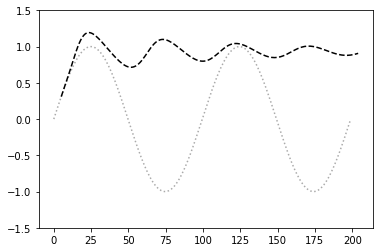

In [5]:
# sin曲線
round_num = 10
div_num = 500
ts = np.linspace(0, round_num * np.pi, div_num)
f = np.sin(ts)

def d_tanh(x):
    return 1/(np.cosh(x)**2 + 1e-4)

# ひとつの時系列データの長さ
maxlen = 5

# sin波予測の入力データ
test_head = [[f[k]] for k in range(0, maxlen)]

data = []
target = []

for i in range(div_num - maxlen):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])
    
X = np.array(data).reshape(len(data), maxlen, 1)
D = np.array(target).reshape(len(data), 1)

# データ設定
N_train = int(len(data) * 0.8)
N_validation = len(data) - N_train

x_train, x_test, d_train, d_test = train_test_split(X, D, test_size=N_validation)

input_layer_size = 1
hidden_layer_size = 5
output_layer_size = 1

weight_init_std = 0.01
learning_rate = 0.1

iters_num = 500

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

us = []
zs = []

u = np.zeros(hidden_layer_size)
z = np.zeros(hidden_layer_size)
y = np.zeros(output_layer_size)

delta_out = np.zeros(output_layer_size)
delta = np.zeros(hidden_layer_size)

losses = []

# トレーニング
for i in range(iters_num):
    for s in range(x_train.shape[0]):
        us.clear()
        zs.clear()
        z *= 0
        
        # sにおける正解データ
        d = d_train[s]

        xs = x_train[s]        
        
        # 時系列ループ
        for t in range(maxlen):
            
            # 入力値
            x = xs[t]
            u = np.dot(x, W_in) + np.dot(z, W)
            us.append(u)
            z = np.tanh(u)
            zs.append(z)

        y = np.dot(z, W_out)
        
        #誤差
        loss = functions.mean_squared_error(d, y)
        
        delta_out = functions.d_mean_squared_error(d, y)
        
        delta *= 0
        for t in range(maxlen)[::-1]:
            
            delta = (np.dot(delta, W.T) + np.dot(delta_out, W_out.T)) * d_tanh(us[t])
            
            # 勾配更新
            W_grad += np.dot(zs[t].reshape(-1,1), delta.reshape(1,-1))
            W_in_grad += np.dot(xs[t], delta.reshape(1,-1))
        W_out_grad = np.dot(z.reshape(-1,1), delta_out)
        
        # 勾配適用
        W -= learning_rate * W_grad
        W_in -= learning_rate * W_in_grad
        W_out -= learning_rate * W_out_grad.reshape(-1,1)
            
        W_in_grad *= 0
        W_out_grad *= 0
        W_grad *= 0

# テスト        
for s in range(x_test.shape[0]):
    z *= 0

    # sにおける正解データ
    d = d_test[s]

    xs = x_test[s]

    # 時系列ループ
    for t in range(maxlen):

        # 入力値
        x = xs[t]
        u = np.dot(x, W_in) + np.dot(z, W)
        z = np.tanh(u)

    y = np.dot(z, W_out)

    #誤差
    loss = functions.mean_squared_error(d, y)
    print('loss:', loss, '   d:', d, '   y:', y)
        
        
        
original = np.full(maxlen, None)
pred_num = 200

xs = test_head

# sin波予測
for s in range(0, pred_num):
    z *= 0
    for t in range(maxlen):
        
        # 入力値
        x = xs[t]
        u = np.dot(x, W_in) + np.dot(z, W)
        z = np.tanh(u)

    y = np.dot(z, W_out)
    original = np.append(original, y)
    xs = np.delete(xs, 0)
    xs = np.append(xs, y)

plt.figure()
plt.ylim([-1.5, 1.5])
plt.plot(np.sin(np.linspace(0, round_num* pred_num / div_num * np.pi, pred_num)), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-  maxlenを5, iters_numを3000にしよう
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

loss: 2.622552933860217e-06    d: [0.90578975]    y: [0.90807997]
loss: 5.660757192504191e-06    d: [-0.6529121]    y: [-0.65627684]
loss: 5.4727479047256475e-06    d: [0.60896952]    y: [0.61227792]
loss: 2.0866875568591546e-07    d: [-0.18775236]    y: [-0.18839837]
loss: 9.736593671753333e-08    d: [0.26742375]    y: [0.26786503]
loss: 2.8453348422824606e-06    d: [-0.88624247]    y: [-0.88862798]
loss: 5.650602420102567e-06    d: [0.66710069]    y: [0.67046242]
loss: 2.307175298079854e-07    d: [0.2855744]    y: [0.28625369]
loss: 7.935033034388533e-06    d: [0.84875167]    y: [0.85273539]
loss: 3.5815971489604832e-06    d: [-0.99583607]    y: [-0.99851249]
loss: 4.864388598404474e-06    d: [0.55785832]    y: [0.56097742]
loss: 3.919191333642986e-06    d: [0.99821192]    y: [1.00101163]
loss: 2.647623003092506e-06    d: [-0.68564779]    y: [-0.68794893]
loss: 3.779223480058946e-06    d: [0.99738016]    y: [1.00012942]
loss: 4.531584837463622e-06    d: [0.77958337]    y: [0.78259388

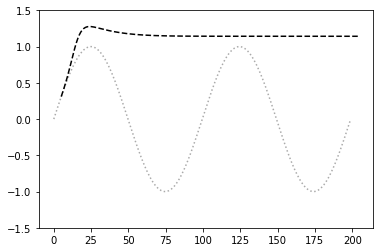

In [6]:
# sin曲線
round_num = 10
div_num = 500
ts = np.linspace(0, round_num * np.pi, div_num)
f = np.sin(ts)

def d_tanh(x):
    return 1/(np.cosh(x)**2 + 1e-4)

# ひとつの時系列データの長さ
maxlen = 5

# sin波予測の入力データ
test_head = [[f[k]] for k in range(0, maxlen)]

data = []
target = []

for i in range(div_num - maxlen):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])
    
X = np.array(data).reshape(len(data), maxlen, 1)
D = np.array(target).reshape(len(data), 1)

# データ設定
N_train = int(len(data) * 0.8)
N_validation = len(data) - N_train

x_train, x_test, d_train, d_test = train_test_split(X, D, test_size=N_validation)

input_layer_size = 1
hidden_layer_size = 5
output_layer_size = 1

weight_init_std = 0.01
learning_rate = 0.1

iters_num = 3000

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

us = []
zs = []

u = np.zeros(hidden_layer_size)
z = np.zeros(hidden_layer_size)
y = np.zeros(output_layer_size)

delta_out = np.zeros(output_layer_size)
delta = np.zeros(hidden_layer_size)

losses = []

# トレーニング
for i in range(iters_num):
    for s in range(x_train.shape[0]):
        us.clear()
        zs.clear()
        z *= 0
        
        # sにおける正解データ
        d = d_train[s]

        xs = x_train[s]        
        
        # 時系列ループ
        for t in range(maxlen):
            
            # 入力値
            x = xs[t]
            u = np.dot(x, W_in) + np.dot(z, W)
            us.append(u)
            z = np.tanh(u)
            zs.append(z)

        y = np.dot(z, W_out)
        
        #誤差
        loss = functions.mean_squared_error(d, y)
        
        delta_out = functions.d_mean_squared_error(d, y)
        
        delta *= 0
        for t in range(maxlen)[::-1]:
            
            delta = (np.dot(delta, W.T) + np.dot(delta_out, W_out.T)) * d_tanh(us[t])
            
            # 勾配更新
            W_grad += np.dot(zs[t].reshape(-1,1), delta.reshape(1,-1))
            W_in_grad += np.dot(xs[t], delta.reshape(1,-1))
        W_out_grad = np.dot(z.reshape(-1,1), delta_out)
        
        # 勾配適用
        W -= learning_rate * W_grad
        W_in -= learning_rate * W_in_grad
        W_out -= learning_rate * W_out_grad.reshape(-1,1)
            
        W_in_grad *= 0
        W_out_grad *= 0
        W_grad *= 0

# テスト        
for s in range(x_test.shape[0]):
    z *= 0

    # sにおける正解データ
    d = d_test[s]

    xs = x_test[s]

    # 時系列ループ
    for t in range(maxlen):

        # 入力値
        x = xs[t]
        u = np.dot(x, W_in) + np.dot(z, W)
        z = np.tanh(u)

    y = np.dot(z, W_out)

    #誤差
    loss = functions.mean_squared_error(d, y)
    print('loss:', loss, '   d:', d, '   y:', y)
        
        
        
original = np.full(maxlen, None)
pred_num = 200

xs = test_head

# sin波予測
for s in range(0, pred_num):
    z *= 0
    for t in range(maxlen):
        
        # 入力値
        x = xs[t]
        u = np.dot(x, W_in) + np.dot(z, W)
        z = np.tanh(u)

    y = np.dot(z, W_out)
    original = np.append(original, y)
    xs = np.delete(xs, 0)
    xs = np.append(xs, y)

plt.figure()
plt.ylim([-1.5, 1.5])
plt.plot(np.sin(np.linspace(0, round_num* pred_num / div_num * np.pi, pred_num)), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.show()